# Práctica 1 - Aprendizaje automatico y minería de datos

Alumnos: Adrián de Lucas Gómez y Andrés Ruiz Bartolomé



In [28]:
from os import makedirs
import numpy as np
from matplotlib import pyplot as plt
from pandas.io.parsers import read_csv
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def carga_csv(file):
    valores = read_csv(file, header=None).to_numpy()
    return valores

## 1. Regresión lineal con una variable


En esta primera parte lo que debiamos hacer era dado unos datos de superficie y precio poder "predecir" cuanto va a costar una casa según su tamaño.
Para ello usamos 2 theta que nos darán la ecuacion de la recta f(x)= theta0 * x + theta1. Las thetas calculan la desviacion de la recta actual sobre los puntos para asi ajustar theta0 y theta1 para la siguente iteracion hasta hacerlas de coste mínimo.

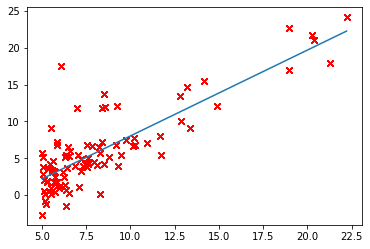

In [29]:
def parte1():
    datos = carga_csv("ex1data1.csv")
    X = datos[:, 0]
    Y = datos[:, 1]

    m = len(X)
    alpha = 0.01
    theta_0 = theta_1 = 0
    for _ in range(1500):
        sum_0 = sum_1 = 0
        for i in range(m):
            sum_0 += (theta_0 + theta_1 * X[i]) - Y[i]
            sum_1 += ((theta_0 + theta_1 * X[i]) - Y[i]) * X[i]
        theta_0 = theta_0 - (alpha/m) * sum_0
        theta_1 = theta_1 - (alpha/m) * sum_1

        plt.plot(X, Y, "x", color="red")
        min_x = min(X)
        max_x = max(X)
        #Para pintar la recta simplemente le pasamos la predicción de
        min_y = theta_0 + theta_1 * min_x
        max_y = theta_0 + theta_1 * max_x

    plt.plot([min_x, max_x], [min_y, max_y])
    plt.show()

parte1()

## 1.1. Visualización de la función de coste
En el segundo apartado de la primera parte debemos de ver los diferentes costes que van teniendo los valores de theta y representarlos en una gráfica bidimensional y tridimensional.
La funcion costeIterativo se encarga de acumular el coste de los valores de theta sobre los casos de prueba.

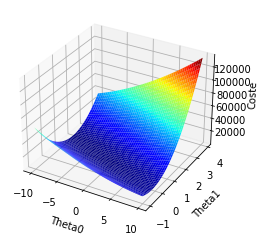

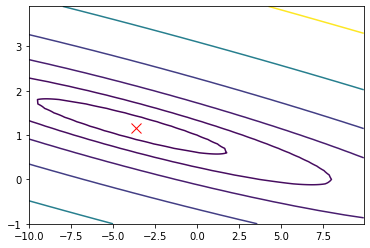

<Figure size 432x288 with 0 Axes>

In [30]:
def costeIterativo(X, Y, theta0, theta1):
    m = len(X)
    sum = 0
    for i in range(m):
        sum += (theta0 + theta1*X[i] - Y[i])**2
    return sum

def make_data(t0_range, t1_range, X, Y):
    step = 0.1
    Theta0 = np.arange(t0_range[0], t0_range[1], step)
    Theta1 = np.arange(t1_range[0], t1_range[1], step)
    Theta0, Theta1 = np.meshgrid(Theta0, Theta1)
    Coste = np.empty_like(Theta0)
    for ix, iy in np.ndindex(Theta0.shape):
        Coste[ix, iy] = costeIterativo(X, Y, Theta0[ix, iy], Theta1[ix, iy])

    return Theta0, Theta1, Coste

def parte1_1():
    datos = carga_csv("ex1data1.csv")
    X = datos[:, 0]
    Y = datos[:, 1]

    m = len(X)
    alpha = 0.01
    theta_0 = theta_1 = 0
    for _ in range(1500):
        sum_0 = sum_1 = 0
        for i in range(m):
            sum_0 += (theta_0 + theta_1 * X[i]) - Y[i]
            sum_1 += ((theta_0 + theta_1 * X[i]) - Y[i]) * X[i]
        theta_0 = theta_0 - (alpha/m) * sum_0
        theta_1 = theta_1 - (alpha/m) * sum_1

    THETA_0, THETA_1, COSTE = make_data([-10, 10], [-1, 4], X, Y)

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(THETA_0, THETA_1, COSTE, cmap=cm.jet)
    ax.set_xlabel("Theta0")
    ax.set_ylabel("Theta1")
    ax.set_zlabel("Coste")
    plt.show()
    plt.clf()

    plt.plot(theta_0, theta_1, marker='x',
             markersize=10, markeredgecolor='red')
    plt.contour(THETA_0, THETA_1, COSTE, np.logspace(-2, 5, 20))
    plt.show()
    plt.clf()
    return 

parte1_1()

## 2. Regresión con varias variables
En la segunda parte de la práctica deberemos de hacer el calculo de una función que prediga el precio de una vivienda pero en esta ocasión además del tamaño se tendrá en cuenta cuantas habitaciones tiene. Debido a esto es necesaria una theta mas y normalizar los datos de entrada.

Se han implementado 2 versiones del gradiente: iterativo y vectorial. El objetivo de estos métodos es el de calcular un nuevo valor para cada una de las Thetas.

El método iterativo va disminuyendo el valor de las thetas segun el salto alfa que tengamos y el valor acumulado de los valores de muestra.

Por su parte el método vectorizado hace uso de una formula en el que los nuevos valores de las thetas restando el valor del vector alfa/casosDePrueba y luego multiplicado por el valor del producto entre los valores de los casos de prueba y la desviacion de la hipótesis y los precios reales.

In [31]:
def gradienteIterativo(X, Y, Theta, alpha):
    NuevaTheta = Theta
    m = np.shape(X)[0]
    n = np.shape(X)[1]
    H = np.dot(X, Theta)
    Aux = (H - Y)
    for i in range(n):
        Aux_i = Aux * X[:, i]
        NuevaTheta[i] -= (alpha / m) * Aux_i.sum()
    return NuevaTheta

def gradiente(X, Y, Theta, alpha):
    NuevaTheta = Theta
    m = np.shape(X)[0]
    n = np.shape(X)[1]
    H = np.dot(X, Theta)
    return Theta-(alpha/m) * np.dot(np.transpose(X), (H-Y))

## 2.1. Implementación vectorizada del descenso de gradiente
La función de coste ahora es vectorizada ya que va a trabajar con arrays de thetas y ademas la hace mas eficiente.

Para normalizar los datos debemos de calcular la media de los 3 valores: precio, superficie y habitaciones. Tambien se calculará la desviación tipica de estos. Con estos resultados y la matriz de datos podremos normalizarlos para su posterior uso.

El descenso de gradiente consiste en dado un numero de iteraciones (100 en nuestro caso) ir reduciendo el coste de las Thetas para calcular otras mejores. Suponemos que llega a la convergencia y que es el mejor valor que podiamos encontrar desde el punto donde comenzamos y devolvemos los thetas y los costes.

In [32]:
def coste(X, Y, Theta):
    H = np.dot(X, Theta)
    Aux = (H - Y) ** 2
    return Aux.sum() / (2 * len(X))

def normMatriz(matriz):
    matriz_norm = np.empty_like(matriz, dtype=np.float32)
    mu = np.empty_like(matriz[0], dtype=np.float32)
    sigma = np.empty_like(matriz[0], dtype=np.float32)

    mu = np.mean(matriz, axis=0)
    sigma = np.std(matriz, axis=0)

    matriz_norm = (matriz-mu) / sigma

    return matriz_norm, mu, sigma


def descenso_gradiente(X,Y,alpha):
    nIteraciones = 100    
    theta = np.zeros(np.shape(X)[1])
    costes = np.zeros(nIteraciones)

    for i in range(nIteraciones):
        costes[i] = coste(X,Y, theta)
        aux = gradiente(X, Y, theta, alpha)
        theta = aux

    return theta, costes

Ahora teniendo estos métodos podemos calcular las thetas y el coste según el alfa que necesitemos. Para ello se va a representar en una grafica de puntos para ver los saltos que dan las thetas segun se van calculando en el descenso de gradiente.

Despues se muestra que valor prevee la funcion con las tetas obtenidas dados unos datos normalizados. Esto servira para comprobar mas adelante con la version que hace uso de la ecuación normal para el cálculo de las thetas.

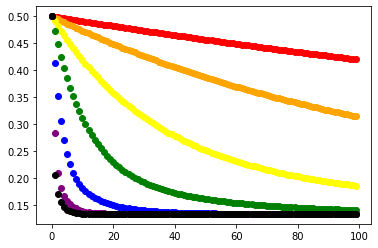

Precio estimado(con descenso de gradiente) de una casa de 1650 pies^2 y 3 habitaciones :  293081.46433510236


In [33]:
def parte2():
    datos = carga_csv("ex1data2.csv")
    datos_norm, media, desviacion = normMatriz(datos)
    X = datos_norm[:, :-1]
    Y = datos_norm[:, -1]
    m = np.shape(X)[0]
    n = np.shape(X)[1]
    X = np.hstack([np.ones([m, 1]), X])

    plt.figure()
    alpha = 0.001
    thetas, costes = descenso_gradiente(X,Y,alpha)
    plt.scatter(np.arange(np.shape(costes)[0]),costes,c='red',label="0.001 ")
    alpha = 0.003
    thetas, costes = descenso_gradiente(X,Y,alpha)
    plt.scatter(np.arange(np.shape(costes)[0]),costes,c='orange',label='0.003')
    alpha = 0.01
    thetas, costes = descenso_gradiente(X,Y,alpha)
    plt.scatter(np.arange(np.shape(costes)[0]),costes,c='yellow',label='0.01')
    alpha = 0.03
    thetas, costes = descenso_gradiente(X,Y,alpha)
    plt.scatter(np.arange(np.shape(costes)[0]),costes,c='green',label='0.01')
    alpha = 0.1
    thetas, costes = descenso_gradiente(X,Y,alpha)
    plt.scatter(np.arange(np.shape(costes)[0]),costes,c='blue',label='0.1')
    alpha = 0.3
    thetas, costes = descenso_gradiente(X,Y,alpha)
    plt.scatter(np.arange(np.shape(costes)[0]),costes,c='purple',label='0.3')
    alpha = 0.5
    thetas, costes = descenso_gradiente(X,Y,alpha)
    plt.scatter(np.arange(np.shape(costes)[0]),costes,c='black',label='0.5')
    
    plt.show()

    pies2Nor= (1650 - media[0]) / desviacion[0]    
    habsNor = (3 - media[1]) / desviacion[1]
    precioPredicho = (thetas[0]+thetas[1]*pies2Nor+thetas[2]*habsNor)*desviacion[2] + media[2]
    print("Precio estimado(con descenso de gradiente) de una casa de 1650 pies^2 y 3 habitaciones : ", precioPredicho)

parte2()

## 2.2. Ecuación normal
Por último calculamos la theta óptima usando la ecuación normal en vez del descenso de gradiente. Para ello seguimos la fórmula de la ecuación normal que nos dice que el nuevo valor para las thetas es el producto de los valores de prueba transpuestos * los valores de prueba normales de cuyo resultado se hace la inversa. Despues se multiplica otra matriz de datos de prueba transpuesta por los valores de los precios. Por último se hace el producto de ambas partes que da como resultado la nueva coleccion de thetas optimas.

La ventaja que ofrece frente a el descenso de gradiente es que se consiguen los valores de theta optimos en una sola pasada mientras que con el descenso de gradiente se deben de hacer un número de iterciones para llegar a la convergencia.

Para mostrar que tienen resultados muy similares tambien hemos usado el mismo caso de prueba que en la otra vesión para corroborar que los resultados son précticamente idénticos.

In [34]:
def ec_normal(matriz, precios):
    first_term = np.linalg.pinv(np.matmul(np.transpose(matriz),matriz))
    second_term = np.transpose(matriz)
    third_term = precios

    theta = np.matmul(np.matmul(first_term , second_term), third_term)

    return theta

def parte2_2():
    datos = carga_csv("ex1data2.csv")
    X = datos[:, :-1]
    Y = datos[:, -1]
    m = np.shape(X)[0]
    n = np.shape(X)[1]
    X = np.hstack([np.ones([m, 1]), X])
    theta = ec_normal(X, Y)

    precioPredicho= theta[1]*1650 + theta[2]*3 + theta[0]    

    print("Precio estimado(con fórmula normal) de una casa de 1650 pies^2 y 3 habitaciones : ", precioPredicho)
    return

parte2_2()

Precio estimado(con fórmula normal) de una casa de 1650 pies^2 y 3 habitaciones :  293081.4643349721
